Values are with in expected ranges. 

In [0]:
from pyspark.sql import functions as F

path_clean = "dbfs:/student-groups/Group_4_4/data_12M/df_joined_1Y_2015_clean.parquet/"

df_joined_1Y_clean = spark.read.parquet(path_clean)

df_joined_1Y_clean.printSchema()
df_joined_1Y_clean.show(5)


root
 |-- ORIGIN: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlyWi

In [0]:
from pyspark.sql import functions as F

numeric_cols = [
    "DEP_DELAY", "CRS_DEP_TIME", "DISTANCE", "DISTANCE_GROUP",
    "HourlyDryBulbTemperature", "HourlyDewPointTemperature",
    "HourlyWetBulbTemperature", "HourlyPrecipitation",
    "HourlyWindSpeed", "HourlyWindDirection", "HourlyVisibility",
    "HourlyRelativeHumidity", "HourlyStationPressure",
    "HourlySeaLevelPressure", "HourlyAltimeterSetting",
]

# Compute basic stats
stats_df = df_joined_1Y_clean.select(numeric_cols).describe()

stats_df.show(50, truncate=False)

# Compute percentiles
percentiles = df_joined_1Y_clean.select([
    F.expr(f"percentile_approx({c}, 0.01)").alias(f"{c}_p01") for c in numeric_cols
] + [
    F.expr(f"percentile_approx({c}, 0.99)").alias(f"{c}_p99") for c in numeric_cols
])

percentiles.show(truncate=False)


+-------+------------------+-----------------+-----------------+------------------+------------------------+-------------------------+------------------------+---------------------+------------------+-------------------+------------------+----------------------+---------------------+----------------------+----------------------+
|summary|DEP_DELAY         |CRS_DEP_TIME     |DISTANCE         |DISTANCE_GROUP    |HourlyDryBulbTemperature|HourlyDewPointTemperature|HourlyWetBulbTemperature|HourlyPrecipitation  |HourlyWindSpeed   |HourlyWindDirection|HourlyVisibility  |HourlyRelativeHumidity|HourlyStationPressure|HourlySeaLevelPressure|HourlyAltimeterSetting|
+-------+------------------+-----------------+-----------------+------------------+------------------------+-------------------------+------------------------+---------------------+------------------+-------------------+------------------+----------------------+---------------------+----------------------+----------------------+
|count 

In [0]:
outlier_counts = []

for c in numeric_cols:
    p = percentiles.collect()[0]
    p01 = p[f"{c}_p01"]
    p99 = p[f"{c}_p99"]

    out_count = df_joined_1Y_clean.filter((F.col(c) < p01) | (F.col(c) > p99)).count()
    total = df_joined_1Y_clean.count()
    pct = out_count / total

    outlier_counts.append((c, out_count, pct))

spark.createDataFrame(outlier_counts, ["feature", "outlier_count", "outlier_pct"]).show(50, truncate=False)


+-------------------------+-------------+--------------------+
|feature                  |outlier_count|outlier_pct         |
+-------------------------+-------------+--------------------+
|DEP_DELAY                |271540       |0.018679921059206697|
|CRS_DEP_TIME             |289656       |0.019926166363429237|
|DISTANCE                 |279342       |0.01921664030537275 |
|DISTANCE_GROUP           |0            |0.0                 |
|HourlyDryBulbTemperature |285444       |0.019636412266421877|
|HourlyDewPointTemperature|217008       |0.014928527322738184|
|HourlyWetBulbTemperature |215492       |0.014824237861422144|
|HourlyPrecipitation      |132502       |0.009115146572096213|
|HourlyWindSpeed          |127754       |0.00878851968401669 |
|HourlyWindDirection      |0            |0.0                 |
|HourlyVisibility         |116432       |0.008009650765137932|
|HourlyRelativeHumidity   |265066       |0.01823455828047316 |
|HourlyStationPressure    |284956       |0.019602841516

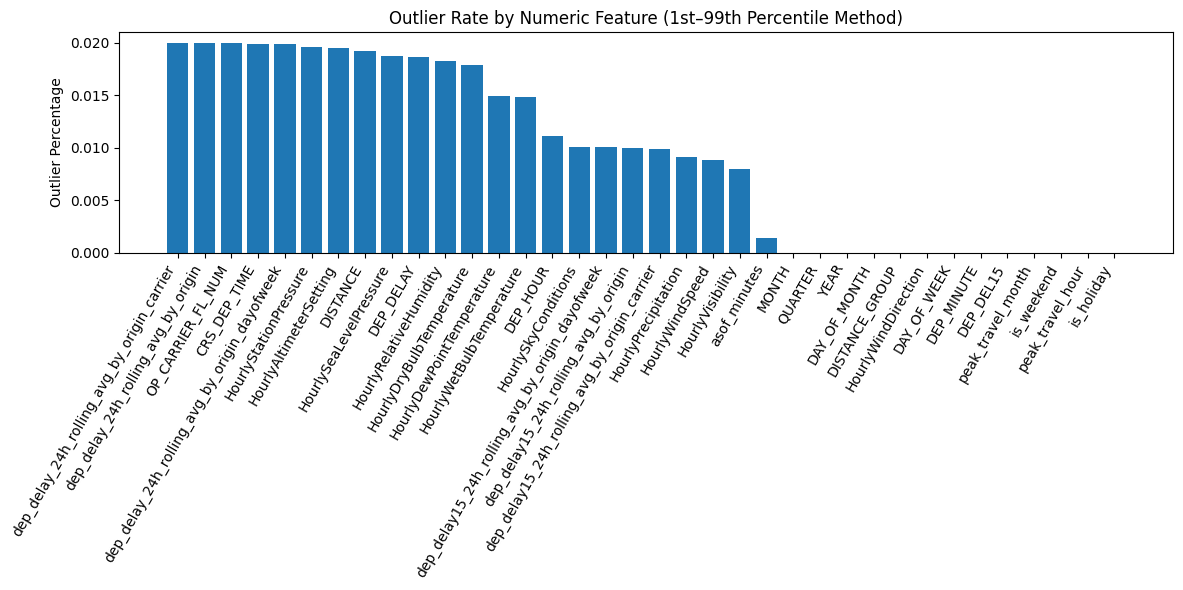

In [0]:
outlier_pdf = outlier_df.toPandas().sort_values("outlier_pct", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(outlier_pdf["feature"], outlier_pdf["outlier_pct"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Outlier Percentage")
plt.title("Outlier Rate by Numeric Feature (1st–99th Percentile Method)")
plt.tight_layout()
plt.show()

Weather features and distance features have the most outliers because they vary naturally. Engineered categorical features have almost none.

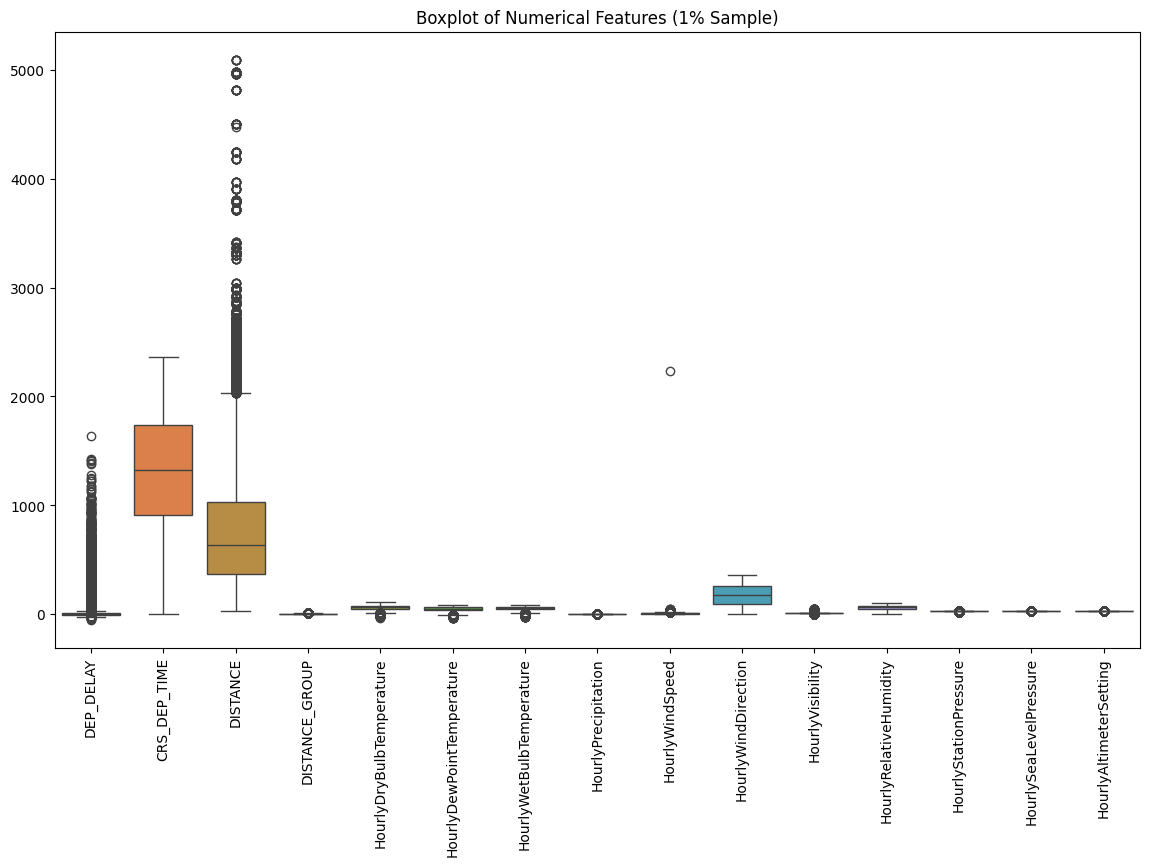

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sample = df_joined_1Y_clean.select(numeric_cols).sample(False, 0.01).toPandas()

plt.figure(figsize=(14, 8))
sns.boxplot(data=sample[numeric_cols])
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Features (1% Sample)")
plt.show()

In [0]:
from pyspark.sql import functions as F

# Load and cache the 1-year features dataset
df = (
    spark.read
    .parquet("dbfs:/student-groups/Group_4_4/data_12M/df_joined_1Y_2015_features.parquet")
    .cache()
)

df.printSchema()
df.count() 


root
 |-- ORIGIN: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlyWi

14536464

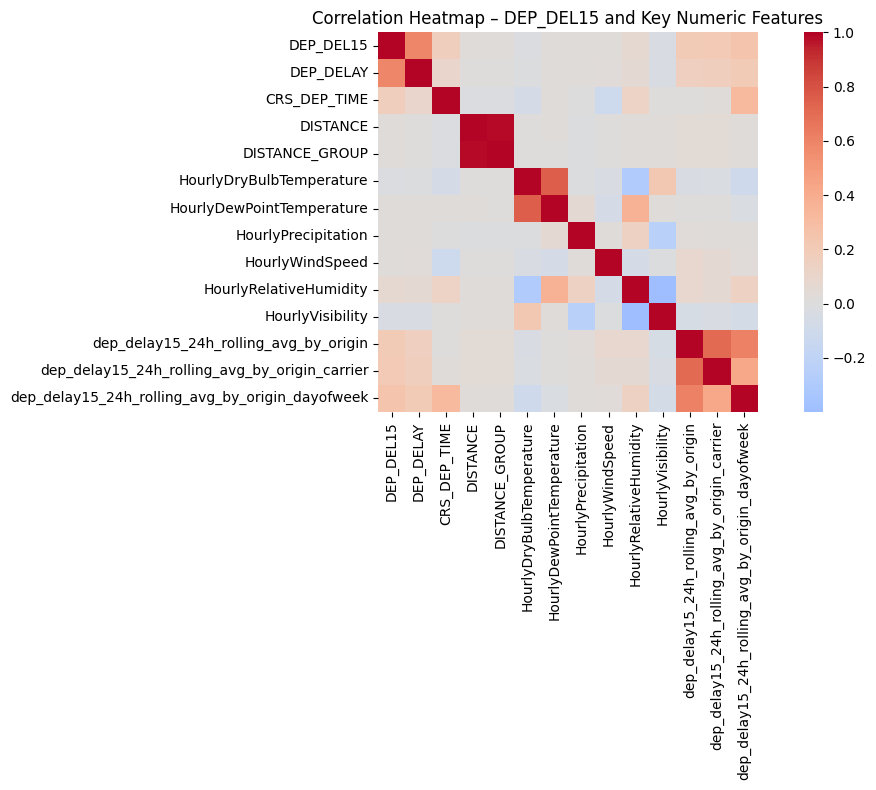

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select a focused set of numeric features for the heatmap
num_cols = [
    "DEP_DEL15",
    "DEP_DELAY",
    "CRS_DEP_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
    "HourlyDryBulbTemperature",
    "HourlyDewPointTemperature",
    "HourlyPrecipitation",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyVisibility",
    "dep_delay15_24h_rolling_avg_by_origin",
    "dep_delay15_24h_rolling_avg_by_origin_carrier",
    "dep_delay15_24h_rolling_avg_by_origin_dayofweek",
]

sample_pdf = (
    df.select([c for c in num_cols if c in df.columns])
      .sample(withReplacement=False, fraction=0.02, seed=42)  # ~2% sample
      .limit(200000)
      .toPandas()
)

corr = sample_pdf.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Correlation Heatmap – DEP_DEL15 and Key Numeric Features")
plt.tight_layout()
plt.show()



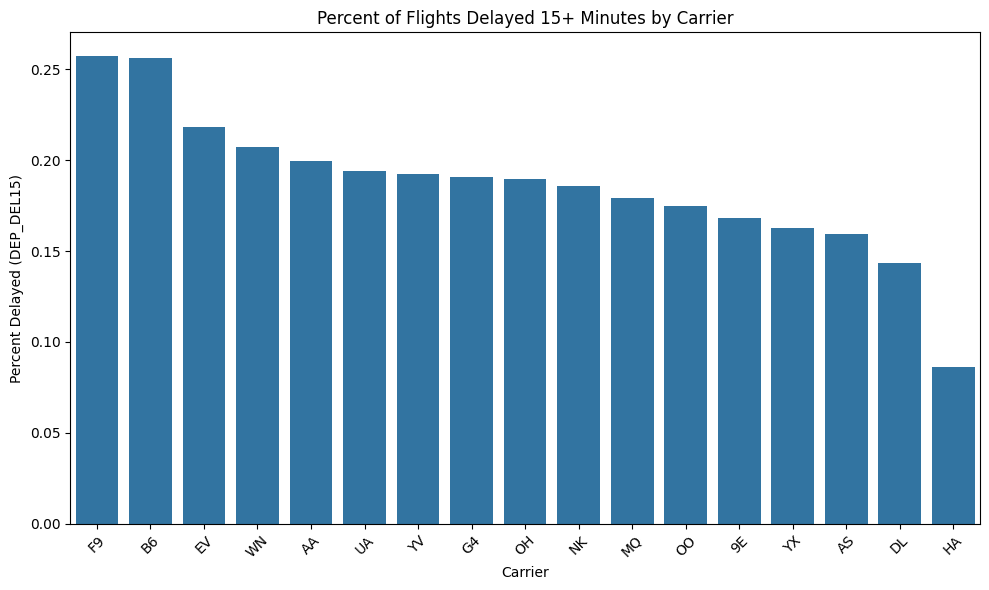

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate percent delayed by carrier
carrier_delay = (
    df.groupBy("OP_CARRIER")
      .agg(F.mean("DEP_DEL15").alias("pct_delayed"))
      .orderBy(F.col("pct_delayed").desc())
      .toPandas()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=carrier_delay,
    x="OP_CARRIER",
    y="pct_delayed"
)
plt.xticks(rotation=45)
plt.ylabel("Percent Delayed (DEP_DEL15)")
plt.xlabel("Carrier")
plt.title("Percent of Flights Delayed 15+ Minutes by Carrier")
plt.tight_layout()
plt.show()


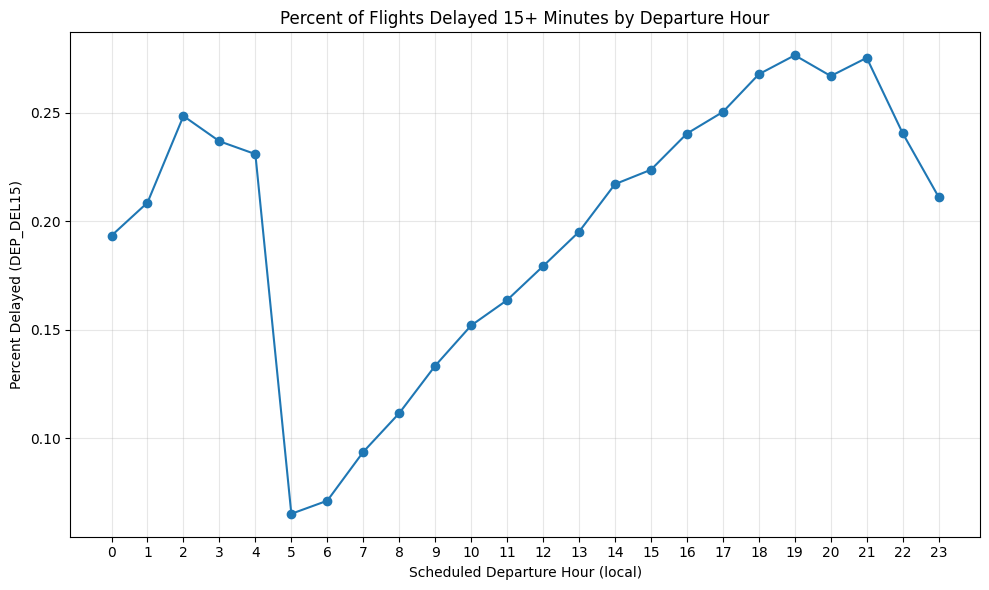

In [0]:
import matplotlib.pyplot as plt

# Aggregate percent delayed by departure hour
hour_delay = (
    df.groupBy("DEP_HOUR")
      .agg(F.mean("DEP_DEL15").alias("pct_delayed"))
      .orderBy("DEP_HOUR")
      .toPandas()
)

plt.figure(figsize=(10, 6))
plt.plot(hour_delay["DEP_HOUR"], hour_delay["pct_delayed"], marker="o")
plt.xticks(range(0, 24))
plt.xlabel("Scheduled Departure Hour (local)")
plt.ylabel("Percent Delayed (DEP_DEL15)")
plt.title("Percent of Flights Delayed 15+ Minutes by Departure Hour")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


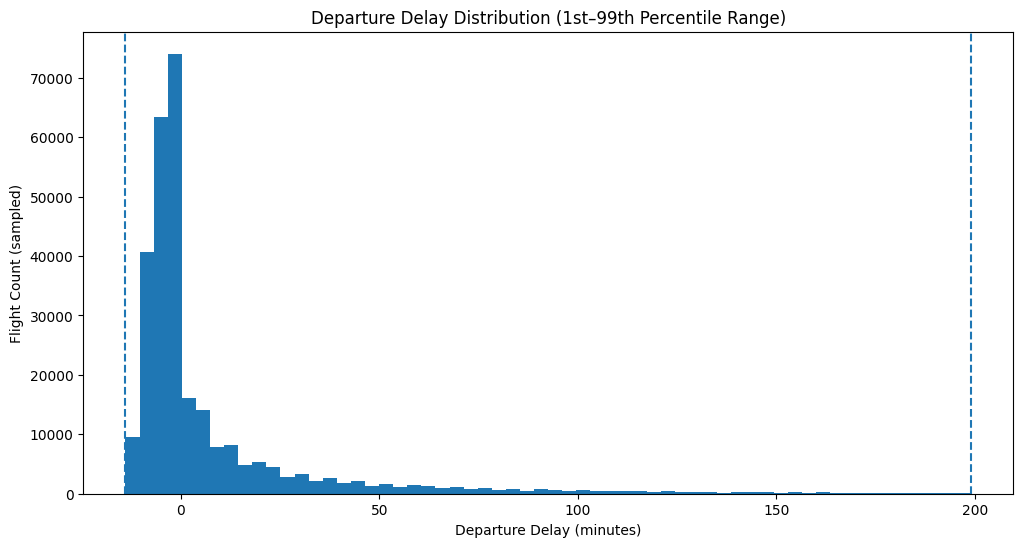

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute percentiles for DEP_DELAY
dep_delay_p = (
    df.select(
        F.expr("percentile_approx(DEP_DELAY, array(0.01, 0.99)) as p")
    )
    .first()
    .p
)
p01, p99 = dep_delay_p[0], dep_delay_p[1]

# Sample for plotting (to keep it fast)
pdf_delay = (
    df.select("DEP_DELAY")
      .where((F.col("DEP_DELAY") >= p01) & (F.col("DEP_DELAY") <= p99))
      .sample(fraction=0.02, seed=42)  # small sample for speed
      .toPandas()
)

plt.figure(figsize=(12,6))
plt.hist(pdf_delay["DEP_DELAY"], bins=60)
plt.axvline(p01, linestyle="--")
plt.axvline(p99, linestyle="--")
plt.title("Departure Delay Distribution (1st–99th Percentile Range)")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Flight Count (sampled)")
plt.show()


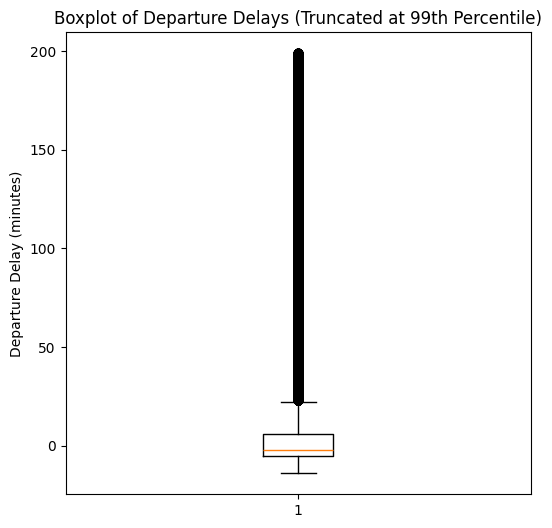

In [0]:
plt.figure(figsize=(6,6))
plt.boxplot(pdf_delay["DEP_DELAY"], vert=True)
plt.title("Boxplot of Departure Delays (Truncated at 99th Percentile)")
plt.ylabel("Departure Delay (minutes)")
plt.show()


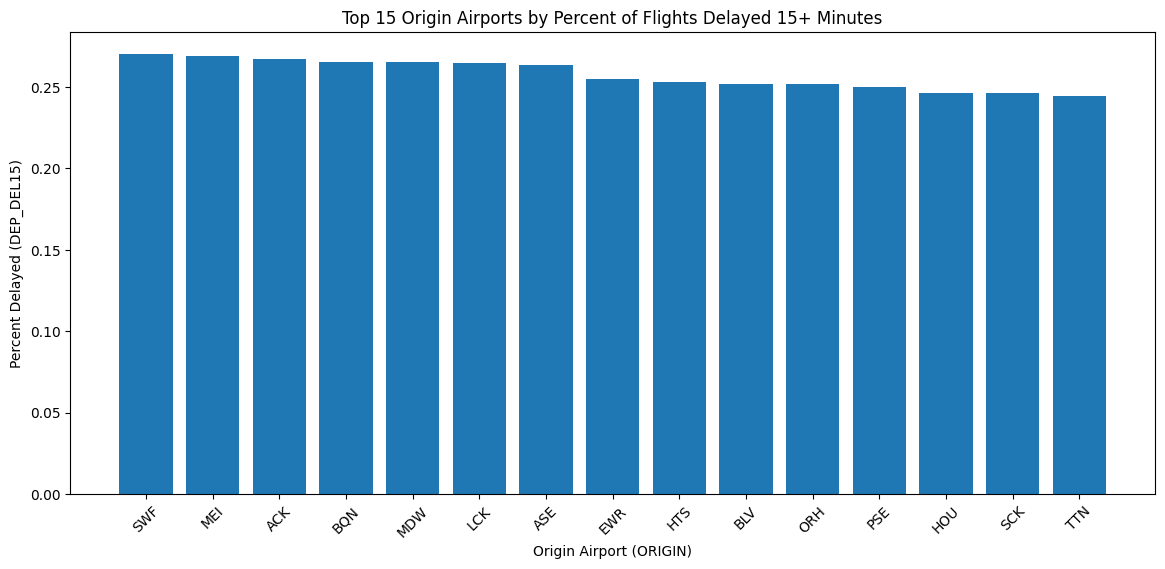

In [0]:
origin_delay = (
    df.groupBy("ORIGIN")
      .agg(F.avg("DEP_DEL15").alias("pct_delayed"), F.count("*").alias("n_flights"))
      .where(F.col("n_flights") >= 1000)   # filter tiny airports
      .orderBy(F.col("pct_delayed").desc())
      .limit(15)
      .toPandas()
)

plt.figure(figsize=(14,6))
plt.bar(origin_delay["ORIGIN"], origin_delay["pct_delayed"])
plt.title("Top 15 Origin Airports by Percent of Flights Delayed 15+ Minutes")
plt.xlabel("Origin Airport (ORIGIN)")
plt.ylabel("Percent Delayed (DEP_DEL15)")
plt.xticks(rotation=45)
plt.show()



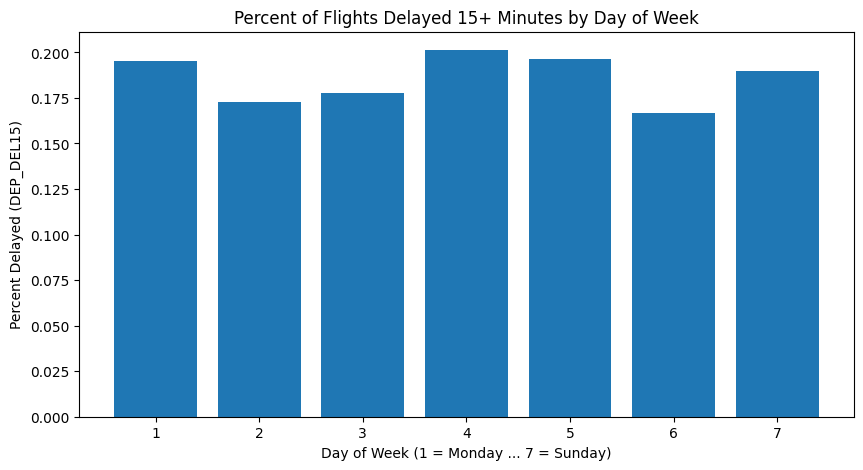

In [0]:
dow_delay = (
    df.groupBy("DAY_OF_WEEK")
      .agg(F.avg("DEP_DEL15").alias("pct_delayed"))
      .orderBy("DAY_OF_WEEK")
      .toPandas()
)

plt.figure(figsize=(10,5))
plt.bar(dow_delay["DAY_OF_WEEK"], dow_delay["pct_delayed"])
plt.title("Percent of Flights Delayed 15+ Minutes by Day of Week")
plt.xlabel("Day of Week (1 = Monday ... 7 = Sunday)")
plt.ylabel("Percent Delayed (DEP_DEL15)")
plt.show()
